In [1]:
#pip install contractions
#pip install spacy-cleaner
#pip install spacy - v 3.41

In [1]:
#pip install -U wheel setuptools

## Start here. 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import spacy
import spacy_cleaner
from spacy_cleaner.processing import removers, replacers, mutators
from albumentations.core.transforms_interface import DualTransform, BasicTransform

In [2]:
train_df = pd.read_csv('Data/train.csv')

In [3]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [4]:
proc_text = [contractions.fix(text) for text in train_df['full_text']]
# Very fast! Measure time later
def more_processing(text):
    text = text.lower()
    return text

proc_text_2 = [more_processing(text) for text in proc_text]

In [5]:
nlp = spacy.load("en_core_web_md", disable=['senter', 'parser', 'ner'])
#nlp.enable("senter")
print(nlp.pipe_names)

pipeline = spacy_cleaner.Pipeline(
    nlp,
    removers.remove_stopword_token,
    removers.remove_punctuation_token,
    replacers.replace_number_token,
    mutators.mutate_lemma_token,
)

/home/rkv/miniconda3/envs/tf/lib/python3.9/site-packages/spacy/language.py:1895: UserWarning: [W123] Argument disable with value ['senter', 'parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


In [6]:
# Remember to switch n_process to 4 when running on Kaggle.

proc_text_3 = pipeline.clean(proc_text_2, n_process = 8, batch_size = 12)
# n_process = 4, batch size 12 - 105 it/s : 00:37

# n_process = 8, default batch size - takes forever to initialize
# n_process = 8, batch size 12 - 141 it/s : 00:27
# n_process = 8, batch size 48 - 130 it/s : 00:29

# n_process = 12, default batch size - takes forever to initialize
# n_process = 12, batch size 12 - 120.3 it/s : 00:29
# n_process = 12, batch size 48 - 89.5 it/s : 00:34


Cleaning Progress: 100%|███████████████████████████████████████████████████████████| 3911/3911 [00:31<00:00, 124.55it/s]


In [4]:
# Contractions mapped, lemmatized, stopwords and punctuations removed, numbers replaced.
proc_text_3[1]

In [8]:
# Also added start of seq and end of seq, lowercase
train_df['cleaned_text'] = proc_text_3

In [9]:
train_df.head()
train_df.to_csv('processed_data_sostok.csv')

## Load this

In [7]:
train_df = pd.read_csv('processed_data_sostok.csv')

In [8]:
train_df.head()

,Unnamed: 0,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cleaned_text
0,0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,< sostok > think student benefit learn home ch...
1,1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,< sostok > problem change let good matter happ...
2,2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,< sostok > dear principal change school policy...
3,3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,< sostok > good time life agree great accompli...
4,4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,< sostok > small act kindness impact people ch...


In [9]:
import random
from albumentations.core.transforms_interface import DualTransform, BasicTransform
from nltk import sent_tokenize
class NLPTransform(BasicTransform):
    """ Transform for nlp task."""
    LANGS = {
        'en': 'english',
        'it': 'italian', 
        'fr': 'french', 
        'es': 'spanish',
        'tr': 'turkish', 
        'ru': 'russian',
        'pt': 'portuguese'
    }

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params

    def get_sentences(self, text, lang='en'):
        return sent_tokenize(text, self.LANGS.get(lang, 'english'))

In [10]:
#trying basic data augmentation: 
class ShuffleSentencesTransform(NLPTransform):
    """ Do shuffle by sentence """
    def __init__(self, always_apply=False, p=0.5):
        super(ShuffleSentencesTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        sentences = self.get_sentences(text, lang)
        random.shuffle(sentences)
        return ' '.join(sentences), lang
    
#https://www.kaggle.com/code/shonenkov/nlp-albumentations/notebook

In [13]:
#print(len(nlp.vocab))

23060


In [11]:
transform = ShuffleSentencesTransform(p=1.0)
transformed_list = []

for iter in train_df['cleaned_text']:
    text = iter
    lang = 'en'
    temp_text = transform(data=(text, lang))['data'][0]
    transformed_list.append(temp_text)

In [12]:
transformed_list[1]

'< sostok > problem change let good matter happen change mind need wake look problem good way change want change time ago problem change different help understand ting wok different example remember come united states think go change think go change different country realist wrong problem change change way remember shy think change lot problem think thing life need different way let happen rue change want problem example think go change need shy anymore need start see different way mad need know go happen people different way know change good let body change way want change choice problem decide _LIKE_NUM_ help understand thing work instance mom lot problem faith people mom scare high scare high understand mos scare high scare high time mom airplane laugh scare funny different way like high understand hoe thing work people example think mom different understand like high need understand help understand thing work need start thing work person life problem change different help understan

In [13]:
train_df['cleaned_text'][1]

'< sostok > problem change let good matter happen change mind need wake look problem good way change want change time ago problem change different help understand ting wok different example remember come united states think go change think go change different country realist wrong problem change change way remember shy think change lot problem think thing life need different way let happen rue change want problem example think go change need shy anymore need start see different way mad need know go happen people different way know change good let body change way want change choice problem decide _LIKE_NUM_ help understand thing work instance mom lot problem faith people mom scare high scare high understand mos scare high scare high time mom airplane laugh scare funny different way like high understand hoe thing work people example think mom different understand like high need understand help understand thing work need start thing work person life problem change different help understan

#### Order has not changed

In [14]:
aug_df = train_df.copy()
aug_df['cleaned_text'] = transformed_list

In [26]:
#aug_df['cleaned_text'][1]

In [15]:
extended_dataset = pd.concat([train_df, aug_df], keys = 'text_id', ignore_index = True)

In [16]:
extended_dataset.tail()

,Unnamed: 0,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cleaned_text
7817,3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,< sostok > believe cellphone class education g...
7818,3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,< sostok > work student argue decission proyec...
7819,3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,< sostok > problem chance good think quote goo...
7820,3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,< sostok > people disagree albert schweitzer q...
7821,3910,FFED00D6E0BD,Do you think that failure is the main thing fo...,3.5,2.5,3.5,3.0,3.0,3.5,< sostok > think failure main thing people con...


In [17]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0
    rare_words = []

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            rare_words.append({key, value})
            count += 1
            frequency += value
    print({
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
        })

    return rare_words

In [18]:
# This is a different tokenizer to the one built into SpaCy
from tensorflow.keras.preprocessing.text import Tokenizer
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(extended_dataset['cleaned_text'])

rare_words = get_rare_word_percent(x_tokenizer, 4)
#print(rare_words)

{'percent': 52.11, 'total_coverage': 1.39, 'count': 9056, 'total_count': 17377}


In [16]:
#rare_words[:100]
#mostly typos in otherwise normal

In [19]:
org_tokenizer = Tokenizer()
org_tokenizer.fit_on_texts(extended_dataset['full_text'])

rare_words_2 = get_rare_word_percent(org_tokenizer, 4)
#print(rare_words)

{'percent': 49.91, 'total_coverage': 0.66, 'count': 11065, 'total_count': 22169}


## y - multi output

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(np.array(extended_dataset['cleaned_text']), np.array(extended_dataset[['cohesion', 'syntax', 'vocabulary',
                                                                                  'phraseology', 'grammar', 'conventions']]), test_size = 0.05, random_state = 0, shuffle = True)

In [9]:
#x_val[:5]

In [21]:
test = np.array(y_val)
test[:5]

array([[3. , 3. , 3. , 3. , 2.5, 3. ],
       [3. , 3. , 3.5, 2. , 2. , 3. ],
       [3.5, 2.5, 2.5, 3. , 3.5, 2.5],
       [3.5, 3. , 3.5, 4. , 3.5, 3. ],
       [3.5, 3. , 2.5, 3. , 3. , 2.5]])

In [22]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-430 words
print(get_word_percent(train_df.cleaned_text, 430))

1.0


## ^This is all that's needed to run the models. Good luck! 

## Embedding matrix for Neural Nets
#### P.S. Following is not needed for the normal classification models.

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_text_len = 450
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='pre')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='pre')

x_vocab_size = len(x_tokenizer.word_index) + 1

print(x_vocab_size)

print(x_train_padded.shape)
print(y_train.shape)
print(x_val_padded.shape)
print(y_val.shape)

17378
(7430, 450)
(7430, 6)
(392, 450)
(392, 6)


In [24]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = 'glove.6B.50d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            #print("Word, i : ", word, i)
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix

embedding_dim = 50
x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)

Found 400000 word vectors.
Converted 10090 words (7287 misses)


In [26]:
x_embedding_matrix.shape

(17378, 50)

In [25]:
x_embedding_matrix[2]

array([ 0.95280999, -0.20608   ,  0.55618   , -0.46323001,  0.73354   ,
        0.029137  , -0.19367   , -0.090066  , -0.22958   , -0.19058   ,
       -0.34856999, -1.02310002,  0.74299997, -0.54890001,  0.88484001,
       -0.14050999,  0.0040139 ,  0.58447999,  0.10767   , -0.44657001,
       -0.43204999,  0.98680001,  0.78288001,  0.51512998,  0.85788   ,
       -1.77129996, -0.88259   , -0.59728003,  0.084934  , -0.48111999,
        3.9677999 ,  0.88929999, -0.27063999, -0.44093999, -0.26212999,
        0.085597  ,  0.022099  , -0.58376002,  0.10908   ,  0.77973002,
       -0.95446998,  0.40482   ,  0.89410001,  0.65250999,  0.39858001,
        0.20884   , -1.32809997, -0.10882   , -0.22822   , -0.46303001])

In [54]:
#root mean squared error
from keras import backend as K 
def root_mean_squared_error(y):
    y_true = y[0]
    y_pred = y[1]
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#tensor containing the RMSE for each column.
def mean_columnwise_root_mean_squared_error(y_true, y_pred):
    all_rmse = tf.map_fn(root_mean_squared_error, (y_true, y_pred), dtype=tf.float32)
    return K.mean(all_rmse)    

In [55]:
from tensorflow.keras import backend as backend
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, dot, Dropout, MaxPooling1D, GlobalAveragePooling1D, Conv1D
import tensorflow as tf
backend.clear_session()
input_dim = len(x_train_padded[0])
input_layer = Input(shape = (input_dim, ))
embedding_layer = Embedding(input_dim = x_vocab_size, 
                    output_dim = embedding_dim, 
                    embeddings_initializer = tf.keras.initializers.Constant(x_embedding_matrix),
                    input_length=max_text_len, trainable = False, mask_zero = True)(input_layer)
conv_1 = Conv1D(128, 2, activation = 'relu')(embedding_layer)
conv_2 = Conv1D(128, 2, activation = 'relu')(conv_1)

# Dropout
dropout_1 = Dropout(0.2)(conv_2)

#conv_3 = Conv1D(128, 2, activation = 'relu')(dropout_1)
#conv_4 = Conv1D(128, 2, activation = 'relu')(conv_3)

# Dropout
#dropout_2 = Dropout(0.2)(conv_4)

# Pooling
pooling_layer = GlobalAveragePooling1D()(dropout_1)

# Output
output_layer = Dense(6)(pooling_layer)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer_obj, loss=mean_columnwise_root_mean_squared_error)
model.summary()

2023-08-03 20:56:13.720366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 20:56:13.726006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-03 20:56:13.726920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-03 20:56:13.727477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 450)]             0         
                                                                 
 embedding (Embedding)       (None, 450, 50)           868900    
                                                                 
 conv1d (Conv1D)             (None, 449, 128)          12928     
                                                                 
 conv1d_1 (Conv1D)           (None, 448, 128)          32896     
                                                                 
 dropout (Dropout)           (None, 448, 128)          0         
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                             

In [57]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss',
                  mode='min', verbose=1, patience=3, min_delta = 0.002),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.000001, verbose=1),
]

In [58]:
history = model.fit(x_train_padded, y_train, epochs=20, validation_data=(x_val_padded, y_val), batch_size = 64, callbacks = callbacks)

Epoch 1/20
Instructions for updating:
Use fn_output_signature instead


2023-08-03 20:56:37.211429: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


117/117 [==============================] - 33s 208ms/step - loss: 1.0194 - val_loss: 0.5813 - lr: 0.0010
Epoch 2/20
117/117 [==============================] - 23s 197ms/step - loss: 0.5712 - val_loss: 0.5728 - lr: 0.0010
Epoch 3/20
117/117 [==============================] - 24s 202ms/step - loss: 0.5555 - val_loss: 0.5521 - lr: 0.0010
Epoch 4/20
117/117 [==============================] - 24s 202ms/step - loss: 0.5422 - val_loss: 0.5427 - lr: 0.0010
Epoch 5/20
117/117 [==============================] - 23s 198ms/step - loss: 0.5347 - val_loss: 0.5359 - lr: 0.0010
Epoch 6/20
117/117 [==============================] - 24s 207ms/step - loss: 0.5308 - val_loss: 0.5342 - lr: 0.0010
Epoch 7/20
117/117 [==============================] - 24s 204ms/step - loss: 0.5245 - val_loss: 0.5283 - lr: 0.0010
Epoch 8/20
116/117 [============================>.] - ETA: 0s - loss: 0.5225
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
117/117 [==============================] - 23

In [59]:
model_json = model.to_json()
with open('saved_models/CNN_Glove50_aug.json', 'w') as f:
    f.write(model_json)

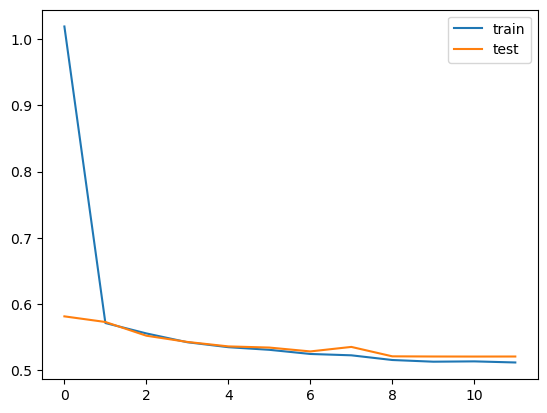

<Figure size 640x480 with 0 Axes>

In [60]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
pyplot.savefig('CNN_Glove50_aug.png')
model.save_weights('saved_models/CNN_Glove50_aug.h5', save_format = 'h5')

In [19]:
#model.save('saved_models/LSTM_combined_dense_1')

In [61]:
from keras.models import model_from_json
with open('saved_models/CNN_Glove50_aug.json', 'r') as f:
    loaded_json = f.read()
    f.close()
    loaded_model = model_from_json(loaded_json)
loaded_model.load_weights('saved_models/CNN_Glove50_aug.h5')

In [62]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 450)]             0         
                                                                 
 embedding (Embedding)       (None, 450, 50)           868900    
                                                                 
 conv1d (Conv1D)             (None, 449, 128)          12928     
                                                                 
 conv1d_1 (Conv1D)           (None, 448, 128)          32896     
                                                                 
 dropout (Dropout)           (None, 448, 128)          0         
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                             

In [63]:
loaded_model.compile(optimizer=optimizer_obj, loss=mean_columnwise_root_mean_squared_error)
scores = loaded_model.evaluate(x_val_padded, y_val, verbose=0)
print("Validation loss: %.2f%%" % (scores*100))

Validation loss: 52.06%


In [64]:
test_scores = loaded_model.predict(x_val_padded)
print("Predicted results: ", test_scores[:10])
print("Actual results: ", y_val[:10])

13/13 [==============================] - 0s 8ms/step
Predicted results:  [[2.9791152 2.8154635 3.0687764 2.8959873 2.645903  2.839581 ]
 [3.139825  3.0315242 3.161587  3.0798905 3.102504  3.1530578]
 [2.8979676 2.7836363 2.980382  2.8388193 2.8295195 2.8044183]
 [2.6402657 2.4814456 2.8023703 2.6057131 2.3655522 2.353733 ]
 [3.007704  2.8908935 3.0137968 2.9445083 2.9685538 3.039684 ]
 [2.7979267 2.6844878 2.895976  2.7663105 2.7271552 2.7472677]
 [2.934377  2.8499887 3.0601065 2.9094417 2.8940878 2.8810172]
 [3.5538042 3.4303553 3.8726373 3.663131  3.2393408 3.465751 ]
 [3.0027506 2.940299  3.0749514 3.018273  3.0730824 3.0424633]
 [3.7440732 3.5808709 3.8382037 3.6695173 3.3504217 3.6476312]]
Actual results:  [[3.  3.  3.  3.  2.5 3. ]
 [3.  3.  3.5 2.  2.  3. ]
 [3.5 2.5 2.5 3.  3.5 2.5]
 [3.5 3.  3.5 4.  3.5 3. ]
 [3.5 3.  2.5 3.  3.  2.5]
 [2.5 2.  2.  2.  2.  2. ]
 [2.5 2.5 3.  3.  2.  2. ]
 [2.5 2.5 3.  2.5 2.  2.5]
 [3.  4.  3.5 3.5 3.  3.5]
 [3.  3.  3.5 3.  2.5 3. ]]


In [65]:
test_scores[1].shape

(6,)

In [66]:
results_df = pd.DataFrame(data = list(zip(test_scores, y_val)), columns = ['Pred_scores', 'Actual'])
results_df.to_csv("CNN_Glove50_aug.csv")

In [67]:
analysis_df = results_df
analysis_df['error'] = results_df['Pred_scores'] - results_df['Actual']
analysis_df.to_csv("CNN_Glove50_aug.csv")
analysis_df.to_pickle("CNN_Glove50_aug.pkl")

In [ ]:
#analysis_df = pd.read_csv("m1_a_m_pre_LSTM_combined_colwise.csv", converters = {'error': pd.eval})

In [27]:
analysis_df = pd.read_pickle("CNN_Glove50_aug.pkl")

In [28]:
analysis_df.head()

,Pred_scores,Actual,error
0,"[2.9791152, 2.8154635, 3.0687764, 2.8959873, 2...","[3.0, 3.0, 3.0, 3.0, 2.5, 3.0]","[-0.02088475227355957, -0.18453645706176758, 0..."
1,"[3.139825, 3.0315242, 3.161587, 3.0798905, 3.1...","[3.0, 3.0, 3.5, 2.0, 2.0, 3.0]","[0.13982510566711426, 0.0315241813659668, -0.3..."
2,"[2.8979676, 2.7836363, 2.980382, 2.8388193, 2....","[3.5, 2.5, 2.5, 3.0, 3.5, 2.5]","[-0.6020324230194092, 0.28363633155822754, 0.4..."
3,"[2.6402657, 2.4814456, 2.8023703, 2.6057131, 2...","[3.5, 3.0, 3.5, 4.0, 3.5, 3.0]","[-0.859734296798706, -0.5185544490814209, -0.6..."
4,"[3.007704, 2.8908935, 3.0137968, 2.9445083, 2....","[3.5, 3.0, 2.5, 3.0, 3.0, 2.5]","[-0.4922959804534912, -0.10910654067993164, 0...."


In [31]:
pred_lst = analysis_df.Pred_scores
actual_lst = analysis_df.Actual
#cohesion 	syntax 	vocabulary 	phraseology 	grammar 	conventions

In [32]:
# flat is faster than item
cohesion_pred_lst = [x.flat[0] for x in pred_lst]
cohesion_act_lst = [x.flat[0] for x in actual_lst]

syntax_pred_lst = [x.flat[1] for x in pred_lst]
syntax_act_lst = [x.flat[1] for x in actual_lst]

vocabulary_pred_lst = [x.flat[2] for x in pred_lst]
vocabulary_act_lst = [x.flat[2] for x in actual_lst]

phraseology_pred_lst = [x.flat[3] for x in pred_lst]
phraseology_act_lst = [x.flat[3] for x in actual_lst]

grammar_pred_lst = [x.flat[4] for x in pred_lst]
grammar_act_lst = [x.flat[4] for x in actual_lst]

conventions_pred_lst = [x.flat[5] for x in pred_lst]
conventions_act_lst = [x.flat[5] for x in actual_lst]

In [69]:
# Predicted scores are not normally distributed. Model is learning something 
# other than the normal distribution. Good news!

In [33]:
iterations = x_val_padded.shape[0]
iterations

392

In [34]:
nonzero_count = []
for num in range(iterations):
    nonzero_count.append(np.count_nonzero(x_val_padded[num]))
#nonzero_count

In [ ]:
#cohesion 	syntax 	vocabulary 	phraseology 	grammar 	conventions

In [36]:
#test_scores[1].shape

In [37]:
proof_df = analysis_df
proof_df['nonzero'] = nonzero_count

In [38]:
pred_scores = np.array((pred_lst))
act_scores = np.array((actual_lst))
print(pred_scores[:5])

[array([2.9791152, 2.8154635, 3.0687764, 2.8959873, 2.645903 , 2.839581 ],
       dtype=float32)
 array([3.139825 , 3.0315242, 3.161587 , 3.0798905, 3.102504 , 3.1530578],
       dtype=float32)
 array([2.8979676, 2.7836363, 2.980382 , 2.8388193, 2.8295195, 2.8044183],
       dtype=float32)
 array([2.6402657, 2.4814456, 2.8023703, 2.6057131, 2.3655522, 2.353733 ],
       dtype=float32)
 array([3.007704 , 2.8908935, 3.0137968, 2.9445083, 2.9685538, 3.039684 ],
       dtype=float32)                                                     ]


<AxesSubplot:>

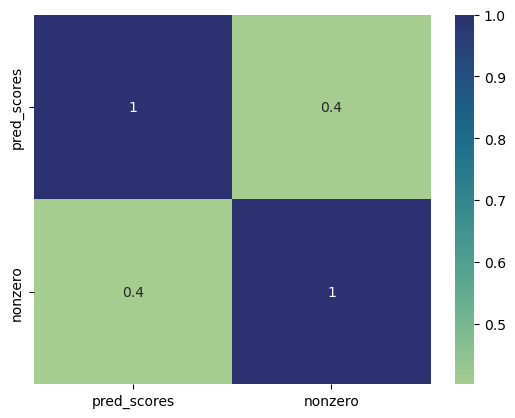

In [39]:
pred_scores_mean = [x.mean() for x in pred_scores]
pred_scores_mean[:5]

corr_df = pd.DataFrame({'pred_scores' : pred_scores_mean, 'nonzero' : nonzero_count})

import seaborn as sns
sns.heatmap(corr_df.corr(), annot = True, cmap = "crest")

#### Actual correlation has been altered by data augmentation (used to be 0.31), but the model is still able to pick up on it well.

<AxesSubplot:>

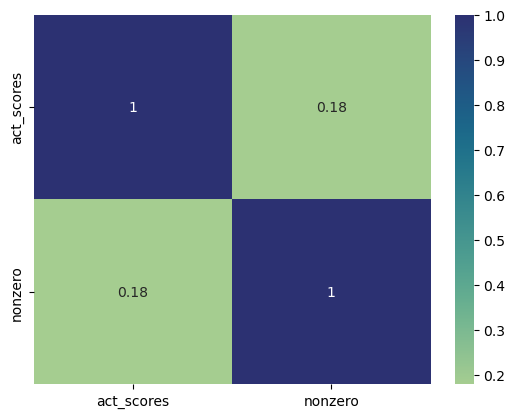

In [41]:
act_scores_mean = [x.mean() for x in act_scores]
act_corr_df = pd.DataFrame({'act_scores' : act_scores_mean, 'nonzero' : nonzero_count})
sns.heatmap(act_corr_df.corr(), annot = True, cmap = "crest")

array([[<AxesSubplot:title={'center':'act_scores'}>]], dtype=object)

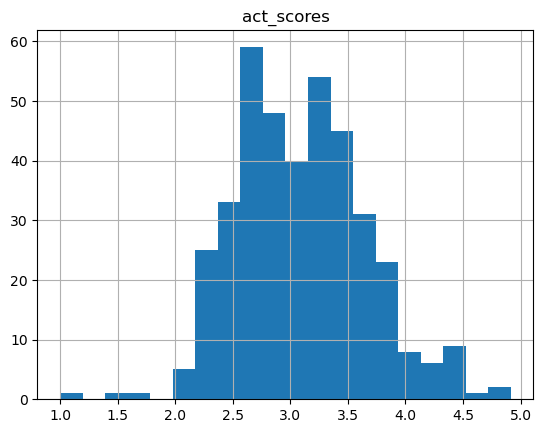

In [42]:
act_corr_df.hist(column = 'act_scores', bins = 20)

### Plotting the mean of the actual and mean of the predicted scores.

array([[<AxesSubplot:title={'center':'pred_scores'}>]], dtype=object)

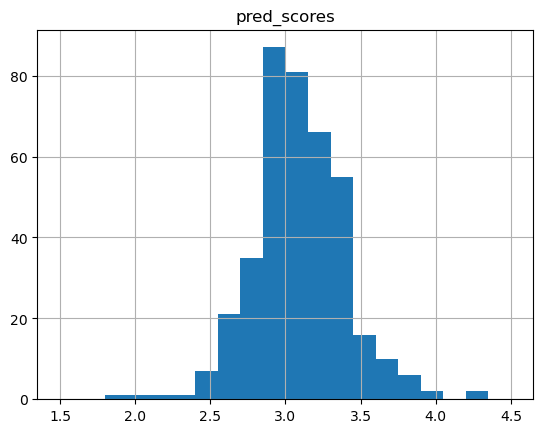

In [43]:
corr_df.hist(column = 'pred_scores', bins = 20, range = [1.5, 4.5])

#### Model's scores are very nicely distributed!!

In [44]:
pred_median_lst = [np.median(x) for x in pred_lst]
pred_med = np.median(pred_median_lst)

act_median_lst = [np.median(x) for x in actual_lst]
act_med = np.median(act_median_lst)

print("Pred median : ", pred_med)
print("Actual median : ", act_med)

Pred median :  3.0758083
Actual median :  3.0


In [45]:
pred_var_lst = [np.var(x) for x in pred_lst]
act_var_lst = [np.var(x) for x in actual_lst]

#print(pred_var_lst)

pred_var = np.mean(pred_var_lst)
act_var = np.mean(act_var_lst)

print("Pred mean variance : ", pred_var)
print("Actual mean variance : ", act_var)

Pred mean variance :  0.011082114
Actual mean variance :  0.11784297052154194


#### Better variance than the non-augmented model.

### Does the model's predicted score roughly follow the actual scores?

In [47]:
corr_df_cohesion = pd.DataFrame({'pred_score' : cohesion_pred_lst, 'act_scores' : cohesion_act_lst})
corr_df_syntax = pd.DataFrame({'pred_score' : syntax_pred_lst, 'act_scores' : syntax_act_lst})
corr_df_vocabulary = pd.DataFrame({'pred_score' : vocabulary_pred_lst, 'act_scores' : vocabulary_act_lst})
corr_df_phraseology = pd.DataFrame({'pred_score' : phraseology_pred_lst, 'act_scores' : phraseology_act_lst})
corr_df_grammar = pd.DataFrame({'pred_score' : grammar_pred_lst, 'act_scores' : grammar_act_lst})
corr_df_conventions = pd.DataFrame({'pred_score' : conventions_pred_lst, 'act_scores' : conventions_act_lst})

Text(0.5, 1.0, 'Cohesion correlation')

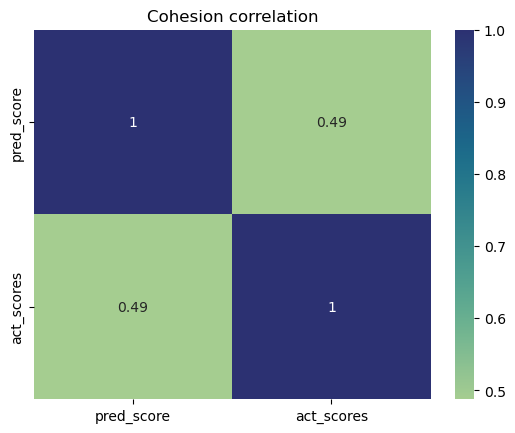

In [48]:
import seaborn as sns
sns.heatmap(corr_df_cohesion.corr(), annot = True, cmap = "crest").set_title("Cohesion correlation")

Text(0.5, 1.0, 'Syntax correlation')

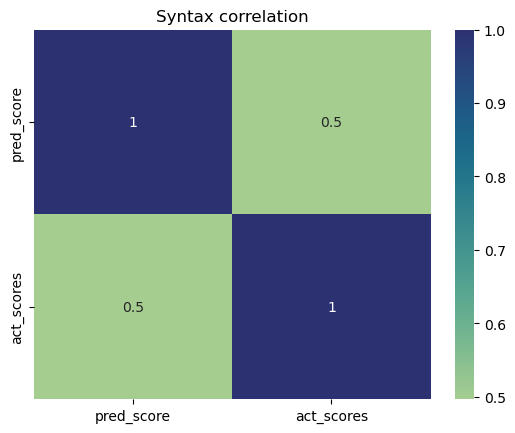

In [49]:
sns.heatmap(corr_df_syntax.corr(), annot = True, cmap = "crest").set_title("Syntax correlation")

Text(0.5, 1.0, 'Vocabulary correlation')

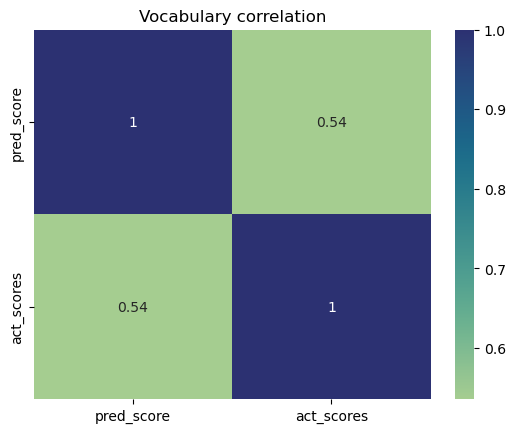

In [50]:
sns.heatmap(corr_df_vocabulary.corr(), annot = True, cmap = "crest").set_title("Vocabulary correlation")

Text(0.5, 1.0, 'Phraseology correlation')

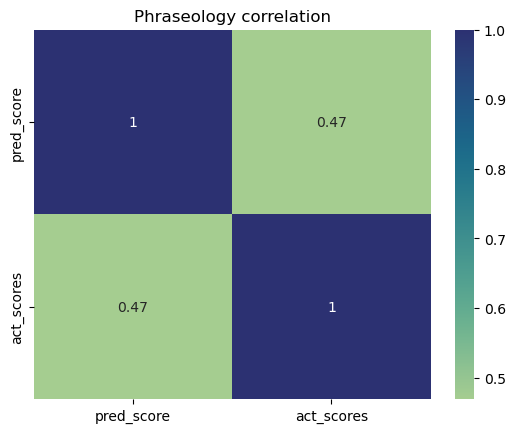

In [51]:
sns.heatmap(corr_df_phraseology.corr(), annot = True, cmap = "crest").set_title("Phraseology correlation")

Text(0.5, 1.0, 'Grammar correlation')

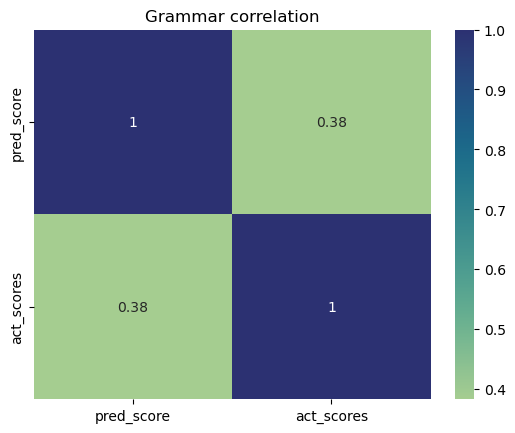

In [52]:
sns.heatmap(corr_df_grammar.corr(), annot = True, cmap = "crest").set_title("Grammar correlation")

Text(0.5, 1.0, 'Conventions correlation')

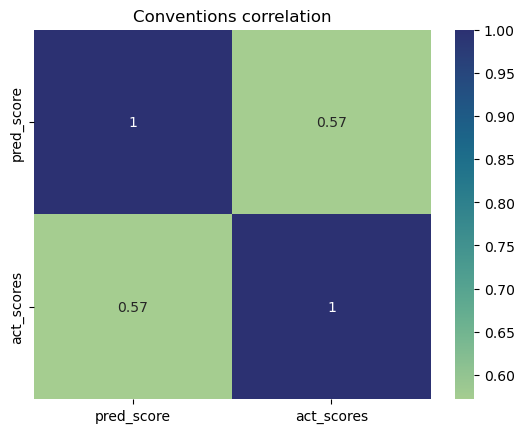

In [53]:
sns.heatmap(corr_df_conventions.corr(), annot = True, cmap = "crest").set_title("Conventions correlation")

#### Despite the really strong correlations, the model seems to perform about the same on the competition dataset. This indicates that the model is starting to overfit on the provided data, and further augmentation would likely reduce it's performance on other data.

#### Even with augmentation, this CNN model cannot learn the grammar score correlation well.